In [1]:
from lazydiff.vars import Scalar, Vector
from lazydiff import ops
import numpy as np
import math
import collections

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
#%matplotlib inline
%matplotlib notebook

In [85]:
dim = 2
X,y,true_coef = make_regression(n_samples = 100, n_features = dim, n_informative = dim, bias = 10, \
                                coef = True, noise = 0, random_state=1)

clf = LinearRegression().fit(X,y)

In [86]:
if (X.shape[1]==1):
    plt.figure()
    plt.scatter(X, y)

In [87]:
def MSE(X, y, param):
    # Y = mx+b
    # last one is the b
    m, b = param[:-1], param[-1]
    loss = Scalar(0)
    for vec, y_i in zip(X,y):
        loss = loss + (sum(m*vec)+b-y_i)**2
    return loss/len(X)

In [88]:
coef = Vector(np.random.rand(X.shape[1]+1))

loss = MSE(X, y, coef)
coef.forward()
loss.grad(coef)
print("forward gives", loss.grad(coef))

loss = MSE(X, y, coef)
loss.backward()
loss.grad(coef)
print("backward gives", loss.grad(coef))

forward gives [ -36.10185146 -132.75281756  -56.94545927]
backward gives [ -36.10185146 -132.75281756  -56.94545927]


In [89]:
# https://github.com/mzhangyb/cs207_matteo_zhang/blob/master/lectures/L04/L4.ipynb
import time
def timer(f):
    def inner(*args):
        t0 = time.time()
        output = f(*args)
        elapsed = time.time() - t0
        print("Time Elapsed", elapsed)
        return output, elapsed
    return inner

In [90]:
def gradientDescent(X, y, loss_function, param, lr = 0.1, forward = True):
    loss = loss_function(X, y, param)
    if (forward):
        # forward mode
        param.forward()
    else:
        # reverse mode
        loss.backward()
    # clear cache by reinstantiating
    param = Vector(param.val-lr*loss.grad(param))
    return param, loss

In [91]:
@timer
def iterative_linear_regression(X, y, param, loss_function, lr = 0.1, epochs = 100, earlyStop = 1e-8, forward = True, plot = False):
    
    #cannot plot unless dimension is 1
    canPlot = X.shape[1] == 1 and plot
    
    if (canPlot):
        plt_range = np.concatenate([min(X),max(X)])
        plt.figure()
        fig,ax = plt.subplots(1,1)
        #plt.ion()
        plt.scatter(X,y)
        line, = plt.plot(plt_range, plt_range*param[0].val+param[1].val, color = 'black', label = 'gradient descent linear regression')
        plt.plot(plt_range, clf.coef_*plt_range+clf.intercept_, alpha = 0.3, label = 'sklearn linear regression')
        plt.xlabel("x value")
        plt.ylabel("y value")
        plt.legend()
        fig.canvas.draw()
    
    loss = Scalar(1e8)
    for i in range(epochs):
        prev = loss
        param, loss = gradientDescent(X, y, loss_function, param, lr, forward)
        if (abs(loss.val - prev.val) < earlyStop):
            break
        if (canPlot):
            line.set_ydata(plt_range*param[0].val + param[1].val)
            ax.set_title("Linear Regression Update epoch = {}\nMSE={:.2E}".format(i, loss.val))
            fig.canvas.draw()
            plt.pause(0.5)
    #return coefficient and intercept
    return param, loss

In [97]:
%matplotlib notebook

coef = Vector(np.random.rand(X.shape[1]+1))
earlyStop = 0#1e-8
plot = True
forward = False
(coef, loss), elapsed = iterative_linear_regression(X, y, coef, MSE, 0.1, 100,
                                                    earlyStop, forward, plot)

Time Elapsed 1.2268328666687012


In [95]:
print("Difference in coeff between iterative vs sklearn: ", coef.val[:-1]-clf.coef_)

Difference in coeff between iterative vs sklearn:  [-5.20910735e-05 -1.31022672e-04]


In [96]:
print("Difference in intercept between iterative vs sklearn: ", coef.val[-1]-clf.intercept_)

Difference in intercept between iterative vs sklearn:  7.495137895396908e-05


In [79]:
time_forward = []
time_backward = []
dim_range = np.arange(1,31,5)
for dim in dim_range:
    print("working on dim={}".format(dim), end='\r')
    X,y, = make_regression(n_samples = 100, n_features = dim, n_informative = dim, bias = 1000, \
                                coef = False, noise = 0, random_state=1)
    # no earlyStop
    earlyStop = 0
        
    forward = True
    coef = Vector(np.random.rand(X.shape[1]+1))
    _, elapsed = iterative_linear_regression(X, y, coef, MSE, 0.1, 100, earlyStop, forward)
    time_forward.append(elapsed)
    
    forward = False
    coef = Vector(np.random.rand(X.shape[1]+1))
    _, elapsed = iterative_linear_regression(X, y, coef, MSE, 0.1, 100, earlyStop, forward)
    time_backward.append(elapsed)

Time Elapsed 0.7752170562744141
Time Elapsed 0.726905107498169
Time Elapsed 2.8221380710601807
Time Elapsed 2.556574821472168
Time Elapsed 5.622174978256226
Time Elapsed 5.007277965545654
Time Elapsed 9.910744190216064
Time Elapsed 8.681136131286621
Time Elapsed 15.728589057922363
Time Elapsed 12.777627944946289
Time Elapsed 21.747325897216797
Time Elapsed 21.64059591293335


<IPython.core.display.Javascript object>


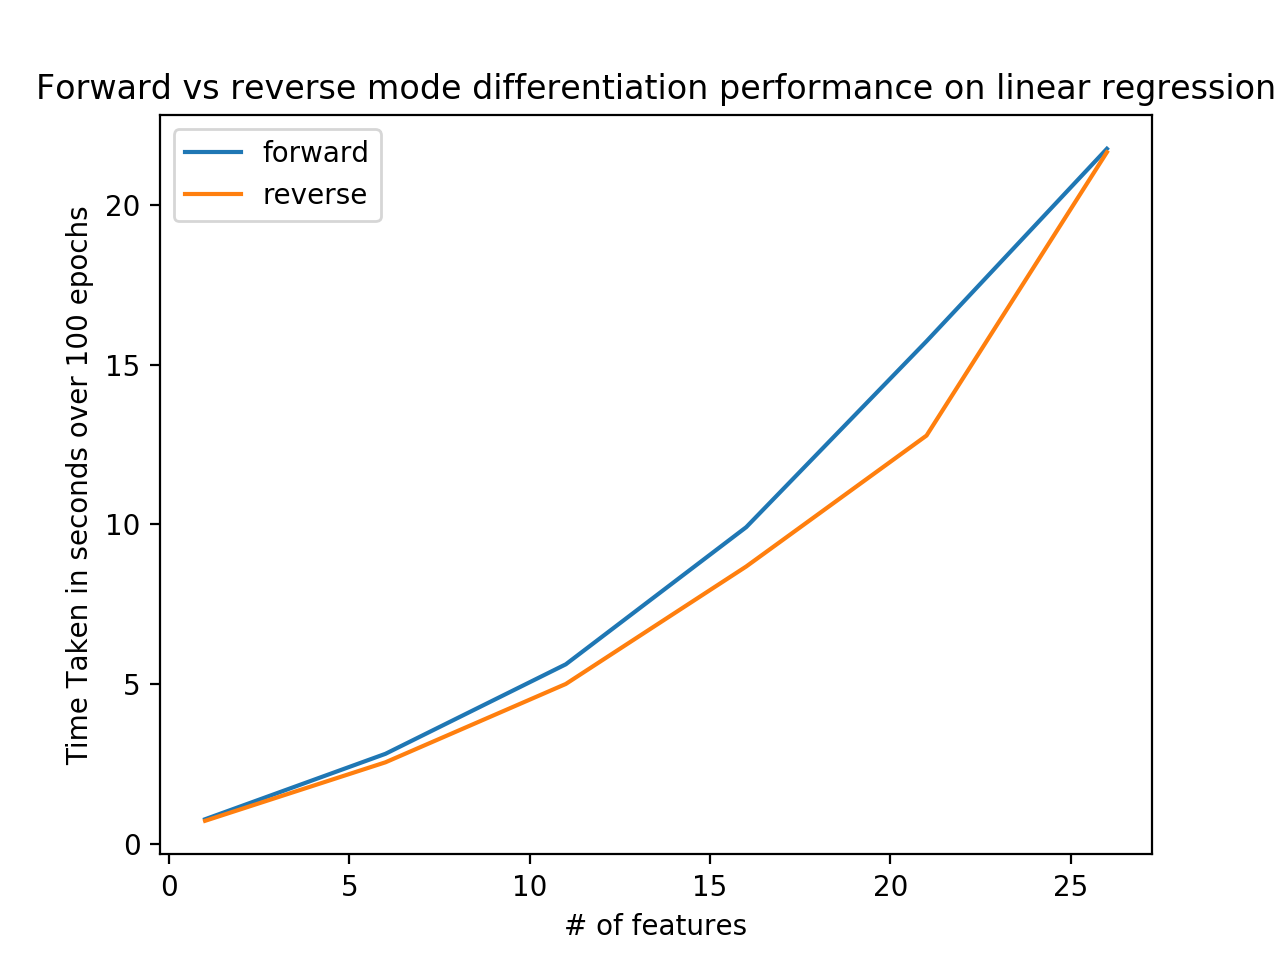

Text(0.5, 1.0, 'Forward vs reverse mode differentiation performance on linear regression')

In [80]:
plt.figure()
plt.plot(dim_range, time_forward, label='forward')
plt.plot(dim_range, time_backward, label='reverse')
plt.legend()
plt.xlabel("# of features")
plt.ylabel("Time Taken in seconds over 100 epochs")
plt.title("Forward vs reverse mode differentiation performance on linear regression")